## Surface Map
### Here we draw a surface map, from data that we retrieve from a THREDDS Data Server.


In [1]:
from datetime import datetime,timedelta
import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeat

from metpy.calc import get_wind_components
from metpy.units import units
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover, wx_code_map

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

#from metargem import calc_clouds, convert_wnum

%matplotlib inline

In [2]:
# Load in a collection of functions that process GEMPAK weather conditions and cloud cover data.
%run /kt11/ktyle/python/metargem.py

In [3]:
# Use the current time, or set your own for a past time.
# Set current to False if you want to specify a past time.

nowTime = datetime.utcnow()
current = True
current = False
if (current):
    validTime = datetime.utcnow()
    year = validTime.year
    month = validTime.month
    day = validTime.day
    hour = validTime.hour
else:
    year = 2019
    month = 1
    day = 30
    hour = 20


validTime = datetime(year, month, day, hour) 
validYear = validTime.strftime("%Y")
validMonth = validTime.strftime("%m")
validDay = validTime.strftime("%d")
validHour = validTime.strftime("%H")
deltaTime = nowTime - validTime
deltaDays = deltaTime.days
print (deltaDays)
earliestDate = nowTime - timedelta(days=365)
timeStr = validTime.strftime("%Y-%m-%d %H UTC")
timeStr2 = validTime.strftime("%Y%m%d%H")
yymmdd = validTime.strftime("%y%m%d")
timeStr2

21


'2019013020'

### If our requested date is more than 7 days old, use the METAR Archive catalog, which goes back one year.
### If the date is more than 365 days old, throw an error and exit.

In [4]:
# UCAR version is all in netCDF
#metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# Albany version is GEMPAK converted to netCDF
if (deltaDays <= 7):
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metar/ncdecoded/catalog.xml?dataset=metar/ncdecoded/Metar_Station_Data_fc.cdmr'
elif (deltaDays <= 365):
    metar_cat_url = 'http://thredds.atmos.albany.edu:8080/thredds/catalog/metarArchive/ncdecoded/catalog.xml?dataset=metarArchive/ncdecoded/Archived_Metar_Station_Data_fc.cdmr'
else:
    print ("Request can only go back one year.")
    print ("Please revise your request accordingly.")
    print ("The earliest date available is: ",earliestDate.strftime("%Y-%m-%d"))
# Parse the xml
catalog = TDSCatalog(metar_cat_url)

metar_dataset = catalog.datasets['Feature Collection']

In [5]:
ncss_url = metar_dataset.access_urls['NetcdfSubset']
# Import ncss client
ncss = NCSS(ncss_url)

What variables do we have available?

In [6]:
ncss.variables

{'ALTI',
 'CEIL',
 'CHC1',
 'CHC2',
 'CHC3',
 'COUN',
 'CTYH',
 'CTYL',
 'CTYM',
 'DRCT',
 'DWPC',
 'GUST',
 'MSUN',
 'P01I',
 'P03C',
 'P03D',
 'P03I',
 'P06I',
 'P24I',
 'PMSL',
 'SKNT',
 'SNEW',
 'SNOW',
 'SPRI',
 'STAT',
 'STD2',
 'STNM',
 'T6NC',
 'T6XC',
 'TDNC',
 'TDXC',
 'TMPC',
 'VSBY',
 'WEQS',
 'WNUM',
 '_isMissing'}

## Now, let's request all stations within a bounding box for a given time and create a surface station plot
 * Make new NCSS query
 * Request data closest to "now", or specify a specific YYMMDDHH yourself.


In [7]:
# Set the domain to gather data from and for defining the plot region.
latN = 47
latS = 37
lonW = -86
lonE = -68
cLat = (latN + latS)/2
cLon = (lonW + lonE )/2

In [8]:
# Create an object to build our data query
# Contract the data query region slightly so it is smaller than the map region.
query = ncss.query()
query.lonlat_box(north=latN-.25, south=latS+.50, east=lonE-.25, west=lonW+.25)
#Adjust time back one minute to avoid THREDDS NCSS "feature" where the next hour
# is queried if minutes = 0
query.time(validTime - timedelta(minutes = 1))

# Select the variables to query.  Note that the variable names depend on the source of the METAR data.
# The 'GEMPAK-like' 4-character names are from the UAlbany THREDDS.

#query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
#                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.variables('TMPC', 'DWPC', 'PMSL',
                'SKNT', 'DRCT','ALTI','WNUM','VSBY','CHC1', 'CHC2', 'CHC3','CTYH', 'CTYM', 'CTYL' )
query.accept('csv')

var=DRCT&var=CHC2&var=CTYH&var=CTYM&var=CTYL&var=DWPC&var=WNUM&var=CHC1&var=CHC3&var=SKNT&var=TMPC&var=VSBY&var=PMSL&var=ALTI&time=2019-01-30T19%3A59%3A00&west=-85.75&east=-68.25&south=37.5&north=46.75&accept=csv

## Create the map using cartopy and MetPy!

### Simple station plotting using plot methods

One way to create station plots with MetPy is to create an instance of `StationPlot` and call various plot methods, like `plot_parameter`, to plot arrays of data at locations relative to the center point.

In addition to plotting values, `StationPlot` has support for plotting text strings, symbols, and plotting values using custom formatting.

Plotting symbols involves mapping integer values to various custom font glyphs in our custom weather symbols font. MetPy provides mappings for converting WMO codes to their appropriate symbol. The `sky_cover` function below is one such mapping.

In [9]:
data = ncss.get_data(query)

lats = data['latitude'][:]
lons = data['longitude'][:]
tair = (data['TMPC'][:] * units ('degC')).to('degF')
dewp = (data['DWPC'][:] * units ('degC')).to('degF')
altm = (data['ALTI'][:] * units('inHg')).to('mbar')
slp = data['PMSL'][:]
#wthr = data['WNUM'][:].astype(int)
# replace missing wx codes or those >= 100 with 0
wnum = (np.nan_to_num(data['WNUM'][:],True).astype(int))
# Convert wind to components
u, v = get_wind_components(data['SKNT'], data['DRCT'] * units.degree)
#u, v = get_wind_components(sknt * units.knots, drct * units.degree)

# Need to handle missing (NaN) and convert to proper code
#cloud_cover = 8 * data['cloud_area_fraction']
#cloud_cover[np.isnan(cloud_cover)] = 10
#cloud_cover = cloud_cover.astype(np.int)
chc1 = (np.nan_to_num(data['CHC1'],True).astype(int))
chc2 = (np.nan_to_num(data['CHC2'],True).astype(int))
chc3 = (np.nan_to_num(data['CHC3'],True).astype(int))
cloud_cover = calc_clouds(chc1, chc2, chc3)

# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
convert_wnum (wnum)

/kt11/ktyle/anaconda3/lib/python3.6/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})
/kt11/ktyle/anaconda3/lib/python3.6/site-packages/metpy/xarray.py:436: MetpyDeprecationWarning: The get_wind_components function was deprecated in version 0.9. This function has been renamed wind_components.
  return func(*args, **kwargs)


The next step deals with the removal of overlapping stations, using  `reduce_point_density`. This returns a mask we can apply to data to filter the points.

In [10]:
from metpy.calc import reduce_point_density

# Project points so that we're filtering based on the way the stations are laid out on the map
proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
xy = proj.transform_points(ccrs.PlateCarree(), lons, lats)

# Reduce point density so that there's only one point within a circle whose distance is specified in meters.
# This value will need to change depending on how large of an area you are plotting.
mask = reduce_point_density(xy, 60000)

Now we just plot with `arr[mask]` for every `arr` of data we use in plotting.

/kt11/ktyle/anaconda3/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/kt11/ktyle/anaconda3/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


Text(0.5,1,'Sfc Map valid at: 2019-01-30 20 UTC')

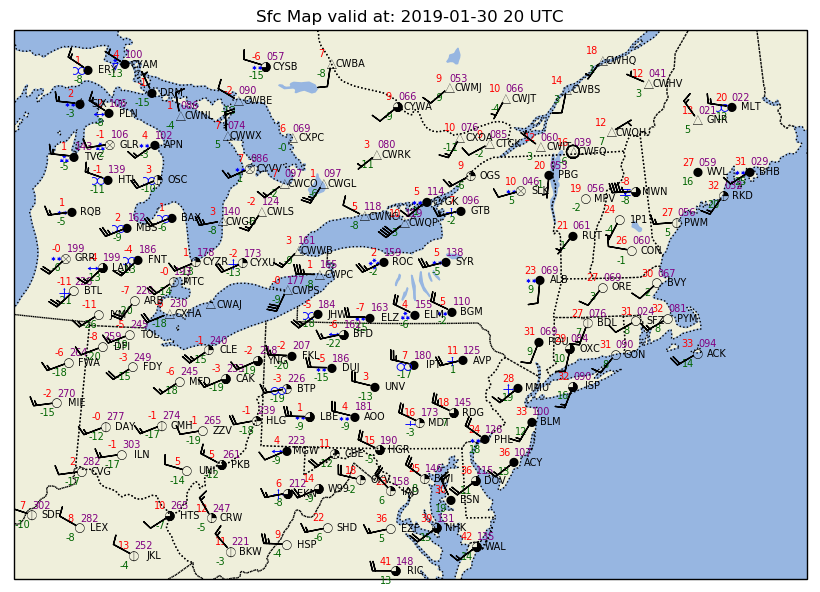

In [11]:
# Set up a plot with map features
dpi = 100
xpix = 1024
ypix = 768
# Figsize is always in inches.  Inches * dpi = pixels.  The line below will produce a 1024 x 768 png when saved to disk.
fig = plt.figure(figsize=(xpix/100,ypix/100), dpi=dpi)

proj = ccrs.Stereographic(central_longitude=cLon, central_latitude=cLat)
ax = fig.add_subplot(1, 1, 1, projection=proj)
land_mask = cfeat.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['land'])
sea_mask = cfeat.NaturalEarthFeature('physical', 'ocean', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['water'])
lake_mask = cfeat.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor='face',
                                        facecolor=cfeat.COLORS['water'])
ax.add_feature(land_mask)
ax.add_feature(sea_mask)
ax.add_feature(lake_mask)

ax.add_feature(cfeat.RIVERS)

ax.set_extent ((lonW,lonE,latS,latN))

state_borders = cfeat.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',
                                         scale='50m', facecolor='none')
ax.add_feature(state_borders, linestyle='dotted', edgecolor='black')

# Create a station plot pointing to an Axes to draw on as well as the location of points
stationplot = StationPlot(ax, lons[mask], lats[mask], transform=ccrs.PlateCarree(),
                          fontsize=7)
stationplot.plot_parameter('NW', tair[mask], color='red')
stationplot.plot_parameter('SW', dewp[mask], color='darkgreen')
# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', slp[mask], color='purple', formatter=lambda v: format(10 * v, '.0f')[-3:])

stationplot.plot_barb(u[mask], v[mask],zorder=100)
stationplot.plot_symbol('C', cloud_cover[mask], sky_cover)
stationplot.plot_symbol('W', wnum[mask], current_weather,color='blue',fontsize=12)
stationplot.plot_text((2, 0), stid[mask])
plt.title("Sfc Map valid at: "+ timeStr)